# Andre typer data

Selv om vi forholder oss mest til tabulære data som vi kan lese fra CSV, SAS eller andre filformater, finnes det masse ikke-tabulære data. Alt fra vanlige tekstfiler (.txt) til JSON til XML til HTML må vi forholde oss til, og her kommer et kræsjkurs i alle disse filtypene.

## Tekstfiler

Vanlige tekstfiler er... ganske vanlig. Disse filene kan leses ved hjelp av en innebygget `open` funksjon. Siden vi ofte forholder oss til både latin1 og utf-8 enkoding vil vi som regel ønske å spesifisere filenkodingen, og for dette bruker vi et innebygget bibliotek som heter `codecs`.

I data-mappen ligger en tekstfil, `allebarna.txt` som inneholder 1395 alle-barna vitser - en vits per linje.

In [1]:
import codecs

allebarna = codecs.open('data/allebarna.txt', 'r', encoding='utf-8').readlines()

In [2]:
len(allebarna)

1395

In [3]:
type(allebarna)

list

`readlines` metoden returnerer en liste med ett element pr linje i tekstfilen. Det går også an å bruker `read()`, som leser hele filen inn som én lang tekststreng, med linjeskift og det hele.

Siden vi allerede kan list comprehensions, er det ingen problem for oss å filtrere denne listen ned til vitser som kun inneholder... f.eks. "Petter".

In [4]:
petter = [vits for vits in allebarna if 'Petter' in vits]

In [5]:
len(petter)

9

Det er altså 9 vitser som omhandler Petter i samlingen vår, som vi kan skrive til fil igjen:

In [6]:
newfile = open('pettervitser.txt', 'w')

newfile.writelines(petter)

newfile.close()

Vi kan legge til at akkurat det samme kan gjøres på linux kommandolinjen, og vi kan kjøre linux-kommandoer fra jupyter ved å starte kodecellen med utropstegn:

In [7]:
! cat data/allebarna.txt | grep 'Petter' > petterlinux.txt

Det som skjer i linux kommandoen er at vi først printer `allebarna.txt` ved hjelp av `cat` kommandoen, og vi sender outputen (såkalt *piper* ved hjelp av pipe symbolet `|`) (linje for linje) til `grep` funksjonen som finner linjer som inneholder "Petter". Resultatet fra grep blir normalt printet til terminalen (også referert til som `STDOUT`), men i dette tilfellet omdirigerer vi outputen til `petterlinux.txt` ved hjelp av `>`.

Hvis du sammenligner de to filene finner du at de er prikk like.

## JavaScript Object Notation

JavaScript Object Notation, minst like godt kjent som JSON, er en måte å representere data på som brukes stadig mer, og som vi i praksis kjenner fra før som dictionaries. Hittil har vi brukt dictionaries til relativt ukompliserte datastrukturer, men JSON er ofte dypt nøster, og element (verdien tilhørende en key) kan være en ny dictionary som igjen kan inneholde nye lister av dictionaries, eller dictionaries med lister av dictionaries. Det kan bli veldig komplisert. Og ofte starter alt med en tekstfil.

I mappen `venmo/` ligger mange tusen json-filer, og hver av de inneholder 20 transaksjoner (pengeoverføringer lignende til vipps) som har blitt utført med venmo-appen. Dette er data som er (var?) åpent tilgjengelig via en API. Å lese flere tusen filer fungerer dårlig hvis vi må hardkode filnavnet, heldigvis kan vi bruke `glob` biblioteket for å lese innholdet i en mappe, og vi vet nok om looper at vi kan lese filene en etter en og prosessere de.

Filene kan leses som vanlige tekstfiler, men for å få Python til å behandle de som noe annet enn vanlige tekststrenger må vi parse de - og til det bruker vi det innebyggede `json` biblioteket.

Men før vi begynner må vi vite hva vi vil. Én ting jeg har lurt på er hvor mange transaksjoner som har flere mottakere. Venmo-appen tillater å betale til flere samtidig, ved at mottaker-feltet er en liste.

In [8]:
import json
import codecs
import glob


In [9]:
venfiles = glob.glob('/data/kurs/python/venmo/*')

print("Antall filer i mappen", len(venfiles))

alle_betalinger = []
failed_entries = []

for entry in venfiles:
    try:
        jfile = open(entry, 'r').read()

        betalings_json = json.loads(jfile)
        alle_betalinger.append(betalings_json)
    except Exception as e:
        failed_entries.append({"file": entry, "error": e})


print("antall parsede element (filer):", len(alle_betalinger))


print("Antall element i første element:", len(alle_betalinger[0]))

xess = [item for sublist in alle_betalinger for item in sublist]

len(xess)

Antall filer i mappen 6925
antall parsede element (filer): 4199
Antall element i første element: 20


83980

In [10]:
failed_entries[1]

{'file': '/data/kurs/python/venmo/vm1014.json',
 'error': json.decoder.JSONDecodeError('Invalid \\escape: line 1 column 11579 (char 11578)')}

Vi ser at det er en del feil i innlesingen, som vi bør se nærmere på. Men enn så lenge er det mer interessant å utforske innholdet i JSON-filene vi har klart å lese. Heldigvis er JSON av typen `dict` når de lastes til Python, og det vet vi hvordan å bruke.

In [11]:
pay1 = xess[0]
type(pay1)

dict

In [12]:
pay1.keys()

dict_keys(['payment_id', 'permalink', 'via', 'action_links', 'story_id', 'comments', 'updated_time', 'audience', 'actor', 'transactions', 'created_time', 'mentions', 'message', 'type', 'likes'])

In [13]:
type(pay1['transactions'])

list

In [14]:
pay1['transactions']

[{'target': {'username': 'alex-gillis1',
   'picture': 'https://venmopics.appspot.com/u/v1/n/8c5316f1-d56c-41d8-81ac-eef45b4c8728',
   'is_business': 'False',
   'name': 'Alex Gillis',
   'firstname': 'Alex',
   'lastname': 'Gillis',
   'cancelled': 'False',
   'date_created': '2016-04-17T23:36:30',
   'external_id': '1930790719979520326',
   'id': '10192710'}}]

In [15]:
multitrx = [trx for trx in xess if len(trx['transactions'])>1]

In [16]:
len(multitrx)

0

OK, det finnes ikke annet enn en-til-en transaksjoner i datasettet vårt, i det minste gjør det videre prosessering enklere. Neste spørsmål er, hvor aktive er brukerne? Hvor mange transaksjoner gjør hver bruker?

In [17]:
usernames = [k['actor']['username'] for k in xess]

In [18]:
len(usernames)

83980

In [19]:
import pandas as pd
df = pd.DataFrame({'uname': usernames})


In [20]:
t = df.groupby('uname').aggregate({'uname': 'count'}).unstack()

In [21]:
type(t)

pandas.core.series.Series

In [22]:
import matplotlib.pyplot as plt

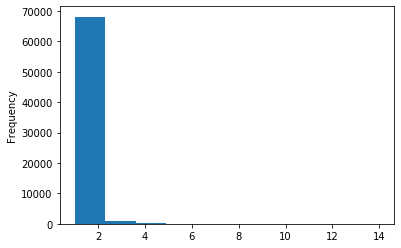

In [23]:
t.plot.hist()

> **Parsing** refererer til å forstå det syntaktiske innholdet i noe. 
> Lingvister bruker ordet når de snakker om hvordan mennesker forstå språk, informatikere snakker om parsing når vi leser
> tekst-filer som har en bestemt struktur eller et format, annet enn bare en streng av tekst.

## XML

XML ser veldig anderles ut enn JSON ved første øyekast, men de er egentlig veldig like. Begge filtypene er veldig hierarkiske, kan inneholder nærmest vilkårlig nøstede strukturer, og krever at vi holder hodet kaldt når vi leser de. Både data fra Altinn, A-ordningen og den nye SIRIUS løsningen til Skatt mottar vi i XML-format. Men stadig oftere ser vi at JSON blir brukt heller enn XML.

En XML-fil består av ulike tag'er, som kan ha attributter, og som kan inneholde enten tekst eller andre tag'er. Et enkelt eksempel kan være:

```
<xml>
    <person>
        <navn type="fornavn">Henrik</navn>
        <navn type="etternavn">Herlung</navn>
    </person>
</xml>
```

Vi kan lese XML som en vanlig tekstfil, men når vi skal parse de må vi ta i bruk et eget bibliotek som er egnet for formålet. Python har noen ulike alternativ, men her bruker vi `ElementTree` som ligger det innebygde `xml` biblioteket. 

In [24]:
import xml.etree.ElementTree as ET

XMLFILE = 'data/court-type.xml'

xmltree = ET.parse(XMLFILE).getroot()

xmltree

<Element 'court-type' at 0x7fd62cdab7c8>

Nå har vi et objekt som representerer XMLen vi leste. Det vi derimot ikke vet, er innholdet i den. For små filer kan det være lurt å lese filen selv for å få en forståelse for hvilke elementer som finnes, og deretter finne de programmatisk. Jupyter forsøker å åpne XML-filer som vanlige nettsider, så det er bedre å skrive filen til konsollen.

For større filer, er det nødvendig å få en egen XML-spesifikasjon, så du vet hva du skal lete etter. Men for å få øvelsen kan vi utforske XMLen ved hjelp av ElementTree.

Nå står vi på toppnivået i XMLen, og det første vi må gjøre er å finne hvilke elementer som ligger rett under:

In [25]:
xmltree.getchildren()

[<Element 'record' at 0x7fd5731349a8>,
 <Element 'record' at 0x7fd57058f9f8>,
 <Element 'record' at 0x7fd5705944a8>]

In [26]:
all_records = xmltree.findall('record')

all_records[0].getchildren()


[<Element 'authority-code' at 0x7fd5fa8c5ae8>,
 <Element 'label' at 0x7fd570c3a958>,
 <Element 'sources' at 0x7fd57058f868>,
 <Element 'start.use' at 0x7fd57058f9a8>]

In [27]:
first_label = all_records[0].find('label')

In [28]:
first_label.getchildren()

[<Element 'lg.version' at 0x7fd570c3ad68>,
 <Element 'lg.version' at 0x7fd570ca7228>,
 <Element 'lg.version' at 0x7fd57058f188>,
 <Element 'lg.version' at 0x7fd57058f1d8>,
 <Element 'lg.version' at 0x7fd57058f228>,
 <Element 'lg.version' at 0x7fd57058f278>,
 <Element 'lg.version' at 0x7fd57058f2c8>,
 <Element 'lg.version' at 0x7fd57058f318>,
 <Element 'lg.version' at 0x7fd57058f368>,
 <Element 'lg.version' at 0x7fd57058f3b8>,
 <Element 'lg.version' at 0x7fd57058f408>,
 <Element 'lg.version' at 0x7fd57058f458>,
 <Element 'lg.version' at 0x7fd57058f4a8>,
 <Element 'lg.version' at 0x7fd57058f4f8>,
 <Element 'lg.version' at 0x7fd57058f548>,
 <Element 'lg.version' at 0x7fd57058f598>,
 <Element 'lg.version' at 0x7fd57058f5e8>,
 <Element 'lg.version' at 0x7fd57058f638>,
 <Element 'lg.version' at 0x7fd57058f688>,
 <Element 'lg.version' at 0x7fd57058f6d8>,
 <Element 'lg.version' at 0x7fd57058f728>,
 <Element 'lg.version' at 0x7fd57058f778>,
 <Element 'lg.version' at 0x7fd57058f7c8>,
 <Element '

Nå har vi gravd oss ned litt, og `first_label` er på stien `court-type/record/label`. Så da må vi bare fortsette, og finne innholdet i `lg.version`:

In [29]:
first_label[0].getchildren()

[]

In [30]:
# ingen barn i lg.version, da kan vi forsøke å skrive ut innholdet:

first_label[0].text

'Съд'

In [31]:
# hmmm... virker egentlig lovende:

first_label[8].text

'Cour de justice'

## Webskraping

For å webskrape data trenger vi et par ting. Vi må (helst) få Python til å få tak i nettsiden vi vil skrape for oss. Deretter må vi forholde oss til innholdet på nettsiden, og hente ut de elementene vi er interessert i. For de som ikke har vært borti HTML, er den gode nyheten at HTML ligner veldig på XML, og mye av den grunnleggende logikken ligner.

Den dårlige nyheten er at HTML som regel er langt mer vilkårlig enn XML, og det trenger ikke å være særlig system i hvordan en nettside er strukturert så lenge noen ganske enkle krav til HTMLen er oppfyllt.

I stedet for ElementTree er det vanlig å bruke et bibilotek som heter `BeautifulSoup` for å parse HTML. Og for å lese nettsider bruker vi et bibliotek som heter `requests`.

Før vi begynner med webskraping er det én ting som vi bør snakke om: Etikk. Det er veldig enkelt å sende en enorm mengde forespørsler til en nettside, noe som kan medføre at nettsiden får ytelsesproblemer, noe som går ut over andre brukere. Derfor må vi tenke oss godt om før vi bestemmer oss for å webskrape, vi må teste koden vår godt for å sikre at vi ikke ved en feil sender masse requests på kort tid ved en feil, og om vi trenger å skrape nettside etter nettside (f.eks. bla oss gjennom en hel katalog) er det nødvendig legge inn pauser i skriptet vårt meed `sleep()` funksjonen fra den innebygde pakken `time`. `sleep` tar antall sekunder den skal vente som argument.

Det er ikke mange nettsider å velge mellom i produksjonssonen, men å webskrape organisasjonskartet på ssb.no er en passende utfordring.

In [32]:
import requests
from bs4 import BeautifulSoup

URL = 'https://www.ssb.no/omssb/om-oss/organisasjonskart'

html = requests.get(URL)

In [33]:
type(html)

requests.models.Response

Resultatet av en request er langt mer enn bare HTMLen, og kanskje det viktigste tilleggselementet er `status_code` som sier hvordan serveren responderte på spørringen. Det fleste kan i hvertfall én sånn kode: 404 not found. Heldigvis er vår statuskode noe annet.

In [34]:
html.status_code

200

Kort fortalt indikerer statuskoder som begynner på 2 at alt har gått bra, statuskoder som begynner på 4 indikerer at serveren er misfornøyd med deg, og statuskoder som begynner på 5 indikerer at serveren er misfornøyd med IT-avdelingen sin.

Selve HTMLen finner vi i `tekst` attributtet, og vi kan parse den som HTML med BeautifulSoup.

In [35]:
soup = BeautifulSoup(html.text)

Nå kommer selve utfordringen: Vi må identifisere og hente ut akkurat de elementene vi trenger. Den beste måten å gjøre dette på er å bruke webutvikler-verktøyene i nettleseren. I vårt tilfelle holder det å finne `span`-elementer som har `class="avdelingsnavn"` som attributt.

In [36]:
avdelinger = soup.find_all('span', attrs={'class': 'avdelingsnavn'})

In [37]:
avdelinger

[<span class="avdelingsnavn">Rådet for Statistisk sentralbyrå</span>,
 <span class="avdelingsnavn">Administrerende direktør</span>,
 <span class="avdelingsnavn">Avdeling for IT</span>,
 <span class="avdelingsnavn">Avdeling for metodeutvikling og datainnsamling</span>,
 <span class="avdelingsnavn">Administrasjonsavdelingen</span>,
 <span class="avdelingsnavn">Avdeling for kommunikasjon og brukerkontakt</span>,
 <span class="avdelingsnavn">Internasjonalt sekretariat</span>,
 <span class="avdelingsnavn">Avdeling for nærings- og miljøstatistikk</span>,
 <span class="avdelingsnavn">Avdeling for økonomisk statistikk</span>,
 <span class="avdelingsnavn">Avdeling for person- og sosialstatistikk</span>,
 <span class="avdelingsnavn">Forskningsavdelingen</span>]

Selv om dette ser ut som en liste med tekst, er dette en liste med bs4-elementer, som i sin tur har nyttige metoder og attributter.

In [38]:
type(avdelinger[0])

bs4.element.Tag

Det eneste som gjensstår nå er å finne selve teksten, noe som er enkelt med `get_text()` metoden og en list comprehension.

In [39]:
avdelingsnavn = [avdeling.get_text() for avdeling in avdelinger]
avdelingsnavn

['Rådet for Statistisk sentralbyrå',
 'Administrerende direktør',
 'Avdeling for IT',
 'Avdeling for metodeutvikling og datainnsamling',
 'Administrasjonsavdelingen',
 'Avdeling for kommunikasjon og brukerkontakt',
 'Internasjonalt sekretariat',
 'Avdeling for nærings- og miljøstatistikk',
 'Avdeling for økonomisk statistikk',
 'Avdeling for person- og sosialstatistikk',
 'Forskningsavdelingen']

## Bilder

Bildeprosessering er noe vi i dag ikke gjør i SSB (i hvertfall ikke i nevneverdig grad).
Dette er imidlertid et område som kan være stor muligheter for å inhente nye kilder eller se på nye muligheter og for nye analyser.

Det er imidertid ikke til å komme unna at dette er et område med stor interesse utenfor SSB.

Som med så mange andre områder har Python biblioteker for å prosessere bilder, et av de vanligste er `PIL`. Vi kommer til å fokusere på enkel bildehåndtering, men dette vil gi et utgangspunkt for videre utforskning for interesserte.

In [40]:
%matplotlib inline
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np

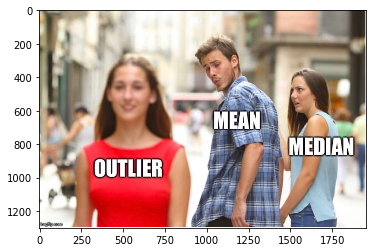

In [41]:
im = Image.open('images/outlier.png')
imshow(np.asarray(im))

In [42]:
type(im)

PIL.PngImagePlugin.PngImageFile

Det er ofte greit å representerer bilder som en numpy-matrise. Det er veldig lett å konvertere fra bilde til numpy.

In [43]:
npimg = np.asarray(im)
npimg.shape

(1300, 1950, 3)

Bildestørrelsen er 1300 x 1950 piksler, og den tredje dimensjonen representerer fargekanalen (RGB). Fra denne matrisen kan vi f.eks. studere metningen i hvert fargelag vha histogram:

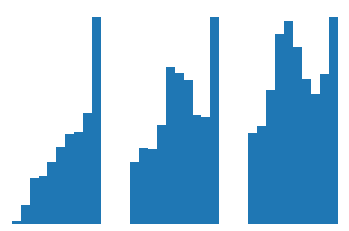

In [44]:
plt.subplot(1, 3, 1)

plt.hist(npimg[:,:,0].flatten())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(npimg[:,:,1].flatten())
plt.axis('off')
plt.subplot(1, 3, 3)
plt.hist(npimg[:,:,2].flatten())
plt.axis('off')
plt.show()

Vi kan også fremstille hver farge for seg.

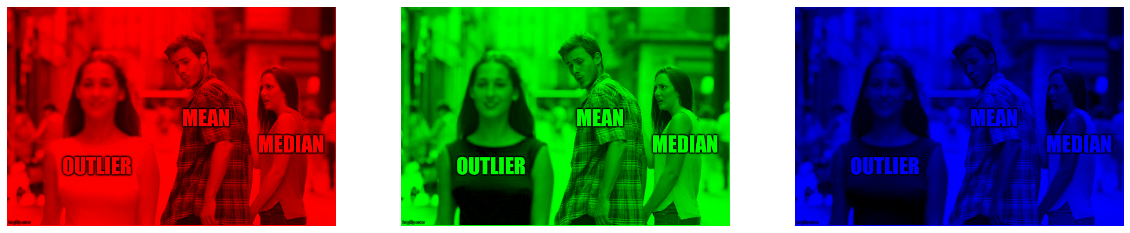

In [45]:
from matplotlib.pyplot import figure

plt.figure(figsize=(20, 10))

zero_fill = np.zeros( (1, npimg.shape[0], npimg.shape[1]))

channel0 = npimg.copy()
channel0[:,:,1] =  zero_fill
channel0[:,:,2]=  zero_fill
imshow(channel0)

channel1 = npimg.copy()
channel1[:,:,0] =  zero_fill
channel1[:,:,2]=  zero_fill
imshow(channel1)

channel2 = npimg.copy()
channel2[:,:,1] =  zero_fill
channel2[:,:,0]=  zero_fill


plt.subplot(1, 3, 1)

imshow(channel0)
plt.axis('off')

plt.subplot(1, 3, 2)
imshow(channel1)
plt.axis('off')
plt.subplot(1, 3, 3)
imshow(channel2)
plt.axis('off')
plt.show()

Vi kan også støylegge bildet:

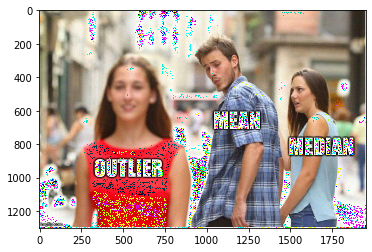

In [46]:
noiseimage = npimg.copy()

layer0 = noiseimage[:,:,0] + np.random.uniform(0, 10, size=(noiseimage.shape[0], noiseimage.shape[1]) ) -5
layer1 = noiseimage[:,:,1] + np.random.uniform(0, 10, size=(noiseimage.shape[0], noiseimage.shape[1] )) -5
layer2 = noiseimage[:,:,2] + np.random.uniform(0, 10, size=(noiseimage.shape[0], noiseimage.shape[1] )) -5

noiseimage[:,:,0] = layer0
noiseimage[:,:,1] = layer1
noiseimage[:,:,2] = layer2

noiseimage[noiseimage<0] = 1
noiseimage[noiseimage>255]= 253

imshow(noiseimage)

Vi kan også konvertere til svart-hvitt ved å ta gjennomsnittet av de tre fargekanalene, og kollapse den tredje dimensjonen.

In [47]:
bw = npimg[:,:,0]/3 +  npimg[:,:,1]/3 + npimg[:,:,2]/3
bw.shape

(1300, 1950)

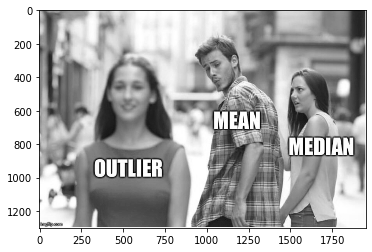

In [48]:
imshow(bw, cmap='gray')

## Prøv selv

Om du ikke kommer på noe selv, kan du prøve følgende:

- I mappen /data/kurs/python/xml_data ligger det en del XML-filer med kryptiske navn. Bruk etree for å utforske filene og kartlegg innholdet. Klarer du å få en forståelse for strukturen og innholdet?

- Fortsett å utforske venmo-dataene: Finnes det gjentatte betalinger mellom de samme personene?